# Singularity Energy Data Exercise

This exercise involves forecasting carbon intensity, from either five minute or hourly data. Additionally given is data on electricity generation by fuel, and carbon intensity by fuel. This notebook serves to lay out the techniques used towards this end.

In [1]:
#Import necessary library packages to render HTML in a code cell
from IPython.display import HTML

#Define the javascript function and HTML to produce the show/hide code button
text = str('''
    <script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [2]:
HTML(text)

## Import Libraries and Data

First, the necessary libraries need to be imported. I have imported several of the basic data science related libaries (numpy/pandas/matplotlib), as well as some extra plotting ones.

Additionally, I am taking a model driven approach to the time series forecasting problem, comparing the class of ARIMA models (with seasonality) to the class of Bayesian Structural Time Series (BSTS) models (also known as Unobserved Components Models). The relevant libraries for these models are imported.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime
import random
import seaborn as sns
from statsmodels.tsa.statespace.structural import UnobservedComponents #BSTS model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #Plotting ACF and PACF graphs
from statsmodels.stats.diagnostic import acorr_ljungbox as ljungbox #Statistical test for autocorrelation
from sklearn.metrics import mean_squared_error as mse
from bokeh.plotting import figure, show #Some nice javascript plotting
from bokeh.io import output_notebook 
from pmdarima.arima import ARIMA #Arima model
from pmdarima.arima import ndiffs, OCSBTest, CHTest
from tabulate import tabulate #Pretty printing
from statsmodels.tsa.stattools import adfuller, kpss #Stationarity tests
plt.style.use('seaborn') #Set plotting to seaborn style
output_notebook()

Loading BokehJS ...

Next the data directory and file paths are defined.

In [5]:
data_dir = Path("ISONE_data")
five_min = pd.read_csv(data_dir / "ISONE_2019_5min.csv")
factors = pd.read_csv(data_dir / "ISONE_2019_factors.csv")
hourly = pd.read_csv(data_dir / "ISONE_2019_hourly.csv")

## Initial Look at Data

First, I will check what the shape of the data is, as well as the data types, and print out the first and last five rows of the dataset. The time column is stored as a string, so I can convert that to a pandas datetime. 

Additionally, given that the time is interval beginning, there is one extra row beyond the full year of 2019. This can be removed for the sake of cleanliness in the challenge.

These steps will be taken in the dataset class defined after.

In [6]:
print(hourly.dtypes)
hourly

Time                 object
Carbon Intensity    float64
Coal                float64
Hydro               float64
Landfill Gas        float64
Natural Gas         float64
Nuclear             float64
Oil                 float64
Other               float64
Refuse              float64
Solar               float64
Wind                float64
Wood                float64
dtype: object


,Time,Carbon Intensity,Coal,Hydro,Landfill Gas,Natural Gas,Nuclear,Oil,Other,Refuse,Solar,Wind,Wood
0,2019-01-01T00:00:00+00:00,445.791089,3.50,1443.00,25.00,5522.08,4014.83,0.0,0.00,358.50,0.0,431.58,356.33
1,2019-01-01T01:00:00+00:00,436.552319,1.50,1235.42,25.00,5051.67,4015.17,0.0,0.00,360.67,0.0,472.25,354.92
2,2019-01-01T02:00:00+00:00,410.122439,1.08,1080.83,25.00,4202.17,4015.67,0.0,0.00,362.00,0.0,503.92,352.75
3,2019-01-01T03:00:00+00:00,387.295648,0.33,1018.92,25.08,3638.92,4016.83,0.0,0.00,358.25,0.0,522.75,352.33
4,2019-01-01T04:00:00+00:00,334.725831,0.00,1411.83,26.00,2914.08,4014.50,0.0,0.00,355.08,0.0,598.92,361.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2019-12-31T20:00:00+00:00,524.592137,2.75,912.33,29.00,6481.42,3337.00,0.0,6.83,362.42,3.0,410.00,291.17
8757,2019-12-31T21:00:00+00:00,522.194197,0.83,1092.42,29.50,6730.25,3336.50,0.0,4.08,352.08,0.5,396.00,289.75
8758,2019-12-31T22:00:00+00:00,520.077070,4.33,1370.92,29.25,7079.42,3333.50,0.0,1.08,346.75,0.0,372.50,294.75
8759,2019-12-31T23:00:00+00:00,517.880952,1.42,1258.25,29.00,6706.33,3334.50,0.0,2.58,344.00,0.0,297.00,292.25


## Creating a Dataset Class (Object Oriented Programming)

Creating a custom class aids in making the code more general, in this case for different intervals of data. Additionally, the initial data quality checks and data type conversions can be streamlined into the class, which are done with the check_interval, check_nulls, and check_blanks functions.

Finally, the sample_ts function is a generalized plotting function that plots a sample time series for an inputted number of days of any number of the columns.

In [7]:
class Dataset:
    def __init__(self, data, time_fmt='%Y-%m-%dT%H:%M:%S', interval = 60):
        self.data = data.copy()
        self.interval = interval
        self.fmt = time_fmt
        self.labels = {k:'lbs/MWh' if k=='Carbon Intensity' else 'MW' for k in self.data.columns.drop('Time')}
        
        self.convert_time()
        self.check_interval()
        self.check_nulls()
        self.check_blanks()
    
    #Convert the object datatype to pandas datetime with defined format
    def convert_time(self):
        len_map = {'%Y' : 4, '%m' : 2, '%d' : 2, '%H' : 2, '%M' : 2, '%S' : 2}
        string = self.fmt
        length = 0
        
        for key, val in len_map.items(): #This for loop is for counting the extra characters in the string
            if key in self.fmt:
                length += val
                string = string.replace(key, '')
        length += len(string)
        self.data['Time'] = self.data['Time'].apply(lambda x: x[:length])
        
        self.data['Time'] = pd.to_datetime(self.data['Time'], format=self.fmt)
        self.data = self.data[self.data.Time.dt.year != 2020]
        print('Datetime Converted')
    
    def check_interval(self): #Check if all of the intervals in the data are equal to the inputted interval
        intervals = self.data.Time.diff().dropna().dt.total_seconds() / 60
        int_set = np.unique(intervals)
        try:
            assert int_set.mean() == self.interval
            self.data.set_index('Time')
            print('All Time Intervals are ' + str(self.interval) + ' Minutes Long')
        except:
            print('Inconsistent Time Intervals Found')
    
    def check_nulls(self): #Check for any nulls in the data
        try:
            assert self.data.isnull().sum().sum() == 0
            print('No Null Cells Found')
        except:
            print(self.data.isnull().sum())
    
    def check_blanks(self): #Check for any string blanks
        try:
            assert self.data.eq('').sum().sum() == 0
            print('No Blank Cells Found')
        except:
            print(self.data.eq('').sum())
    
    #This functions plots a sample time series of any number of columns
    def sample_ts(self, columns, days=7, cols=3, sharey=False):
        rand_start = np.random.choice(self.data[(self.data.Time.dt.hour==0)&(self.data.Time.dt.minute==0)]['Time'])
        rand_start = pd.to_datetime(rand_start, format='%Y-%m-%dT%H:%M:%S')
        rand_end = rand_start + datetime.timedelta(days=days)
        subset = self.data[(self.data.Time >= rand_start)&(self.data.Time <= rand_end)].copy()
        cols = min(len(columns), cols)
        rows = max(1, int(np.ceil(len(columns) / cols)))
        fig, axes = plt.subplots(rows, cols, sharex=True, sharey=sharey, figsize=((5*cols), (5 * rows)))
        for i, col in enumerate(columns):
            if rows > 1:
                row_num = int(np.floor(i / cols))
                ax = axes[row_num]
            else:
                ax = axes
            if cols > 1:
                col_num = i % cols
                ax = ax[col_num]
            subset.plot(x='Time', y=col, ax=ax, legend=False)
            ax.set_ylabel(col + ' ' + '(' + self.labels[col] + ')')
        

Next, the dataset can be defined as an instance of the above class. The print statements automatically show that all data quality checks are passed, indicating that no there is no missing data in the hourly set. This also indicates that the data is not in daylight savings time, which is also common in data from the ISO's. If this were the case, we could convert the time series from daylight savings time to standard time. This would help with joining to other data sources, however, it would remove a row, becoming an 8759 rather than 8760.

If there was missing data however, one common method is to use some form of interpolation. For the shape and curvature often found in electricity data, spline interpolation is often a good choice.|

In [8]:
hourly_set = Dataset(hourly)

Datetime Converted
All Time Intervals are 60 Minutes Long
No Null Cells Found
No Blank Cells Found


Next, some basic summary statistics about the hourly dataset are displayed. We can see that each column of data has a full set of observations. Additionally, the mins and maxs of the data are all as expected, the data is non-negative.

Some of the fuel sources are more variable than others, which can be seen comparing either their standard deviations, or their ranges of 25-75 percentiles. Nuclear, as expected has a lower variation relative to its average, whereas Coal, Wind, and Solar have higher variations.

In [9]:
pd.options.display.float_format = '{:.2f}'.format
hourly_set.data.describe().stack().unstack(level=0)

,count,mean,std,min,25%,50%,75%,max
Carbon Intensity,8760.00,486.67,78.26,253.51,429.02,483.47,543.34,701.38
Coal,8760.00,51.06,135.17,0.00,0.00,0.92,13.60,900.33
Hydro,8760.00,914.86,424.20,220.58,616.46,880.38,1177.85,2519.50
Landfill Gas,8760.00,25.60,6.45,0.00,25.42,28.00,29.00,32.00
Natural Gas,8760.00,5424.82,2155.78,1127.58,3829.80,5171.00,6547.77,14140.25
Nuclear,8760.00,3403.42,469.70,1905.42,3309.08,3331.50,3885.42,4034.42
Oil,8760.00,17.92,96.64,0.00,0.00,0.00,0.00,1696.25
Other,8760.00,4.67,6.43,0.00,0.00,2.67,6.25,151.50
Refuse,8760.00,346.21,31.03,241.25,326.23,348.75,368.52,415.67
Solar,8760.00,24.27,36.52,0.00,0.00,3.00,37.00,149.67


Looking at a sample time series plot over 7 days of each column of data, we can see that many of the data series' exhibit a daily seasonality, which is crucial to account for in a forecasting model. Some fuel sources however, such as Nuclear, Coal, and Wind, do not exhibit a defined daily pattern.

**Of particular importance to note is my choice to set each graph at a different scale on the y-axis. I made this choice as this graph was used to visualize the different seasonal patterns of the data, but the visual level of each fuel source should not be compared.**

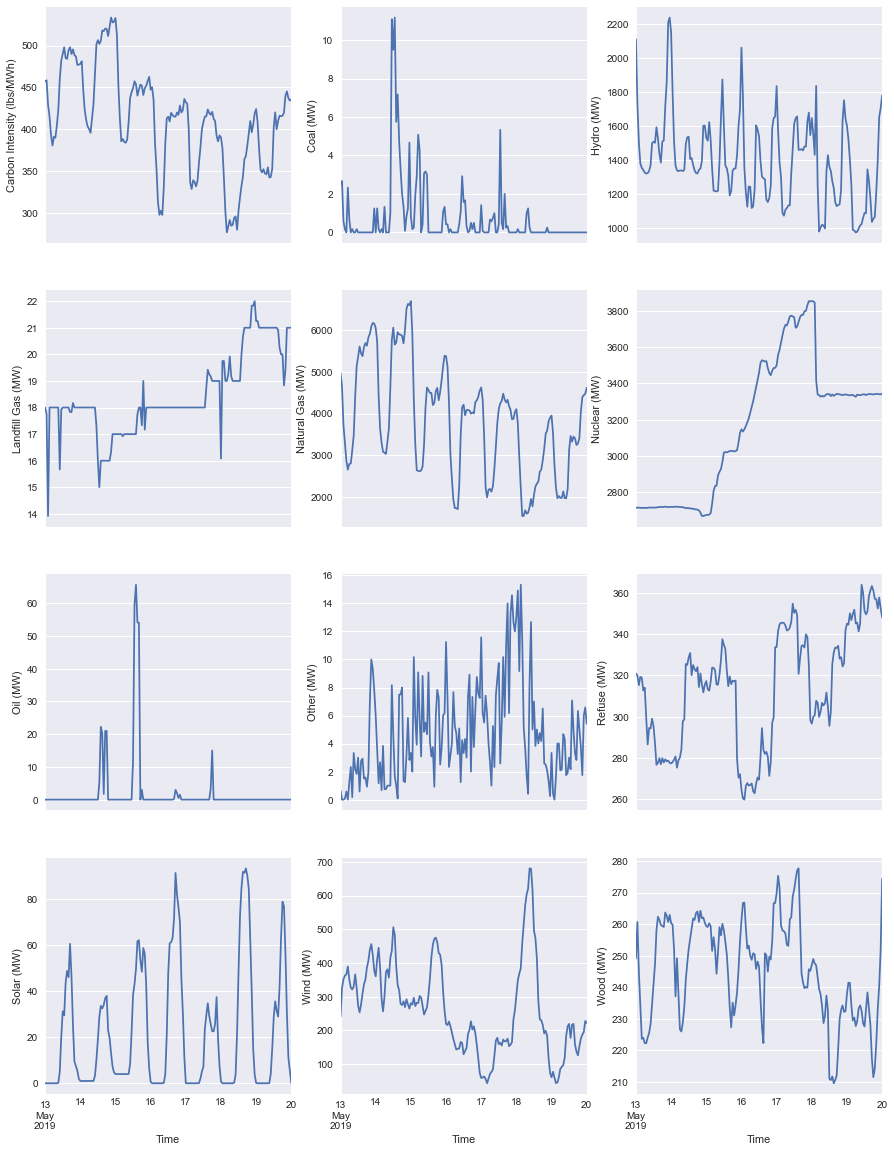

In [10]:
non_time = [col for col in hourly_set.data.columns if col != 'Time']
hourly_set.sample_ts(non_time, days=7)

Finally, a useful tool for exploratory data analysis is a correlation matrix heatmap, which can be done cleanly with seaborn. This heatmap plots the correlation coefficient matrix for all of the data.

As expected, Nuclear, Wind, and Hydro are negatively correlated with carbon intensity, while Coal, Oil, and Natural Gas are positively correlated. However, we can see that solar is also positively correlated with Carbon Intensity. This does seem paradoxical at first, but the answer lies in understanding the daily patterns of the data in the plot above. We can see both visually above and in the heatmap below that solar is positively correlated with natural gas. This explains the positive correlation of solar with Carbon Intensity.

<AxesSubplot:>

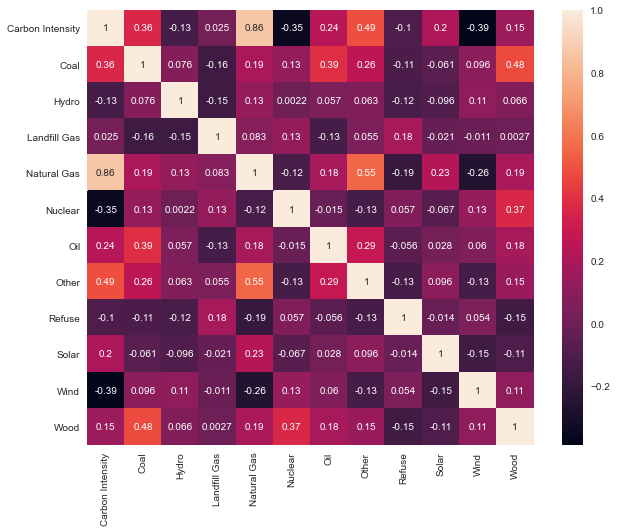

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(hourly_set.data[non_time].corr(), ax=ax, annot=True)

Finally, thinking about the kind of forecasting models that would be suitable to this problem setting, and given that we have the additional data separated by fuel type, a multivariate time series model, such as a Vector Autoregression (VAR) or structural VAR (SVAR) could be used. Additionally, many other popular machine learning techniques could be used, such as neural networks or random forests.

However, for this exercise, I will stick with the class of SARIMA and BSTS models. These allow for more interpretability into the components of the model, and control over the type of model. It is usually better to start with a simpler model whose components are well understood and validated before moving onto other techniques.

## Creating a Model Class

Next, we can make a model class that is a parent of/inherits from the dataset class. The model class will all of the attributes and functions of the dataset class, in addition to its own.

In this class, I define some functions to run the bsts and arima models, as well as evaluate, compare, and visualize their performance and forecasts. The class is generalized to take in any of the columns as the series, and to take in either the hourly or five minute data. However the functionality for a multivariate model such as a VAR is not taken into account.

In [12]:
class Model(Dataset):
    def __init__(self, data, series, time_fmt='%Y-%m-%dT%H:%M:%S', interval = 60):
        super().__init__(data, time_fmt=time_fmt, interval=interval)
        self.models = {'bsts' : None, 'arima' : None}
        self.results = {'bsts' : None, 'arima' : None}
        self.predictions = {'bsts' : None, 'arima' : None}
        self.residuals = {'bsts' : None, 'arima' : None}
        self.series = series
        self.y = self.data[series]
        self.x = self.data['Time']
        self.forecasts = {'bsts' : None, 'arima' : None}
    
    def check_diff(self, seasonal=None):
        n_adf = ndiffs(self.y, test="adf")
        n_kpss = ndiffs(self.y, test="kpss")
        print('Number of Differences Suggested by ADF Test = ' + str(n_adf))
        print('Number of Differences Suggested by KPSS Test = ' + str(n_adf))
        if seasonal:
            seasonal = int(seasonal * (60 / self.interval))
            n_ocsb = OCSBTest(m=seasonal).estimate_seasonal_differencing_term(self.y)
            n_ch = CHTest(m=seasonal).estimate_seasonal_differencing_term(self.y)
            print('Number of Seasonal Differences Suggested by OCSB Test = ' + str(n_ocsb))
            print('Number of Seasonal Differences Suggested by CH Test = ' + str(n_ch))
    
    def bsts(self, args={}): #Function to run the bsts model, with some predefined parameters
        bsts_args = {'level' : True, 'trend' : True, 'seasonal' : 24, 'cycle' : True,
               'autoregressive' : 1, 'irregular' : True, 'stochastic_cycle' : True,
                'stochastic_level' : True}
        bsts_args['seasonal'] = int(bsts_args['seasonal'] * (60 / self.interval))
        bsts_args.update(args)
        
        self.models['bsts'] = UnobservedComponents(self.y, **bsts_args)
        self.results['bsts'] = self.models['bsts'].fit()
        self.predictions['bsts'] = self.results['bsts'].predict()
        self.residuals['bsts'] = self.predictions['bsts'] - self.y
        self.forecasts['bsts'] = self.results['bsts'].forecast(steps=24)
    
    def arima(self, p=1, q=1, interval=24, d=0, D=0):
        interval = int(interval * (60 / self.interval))
        
        self.models['arima'] = ARIMA(order=(p, d, q), seasonal_order=(1, D, 0, interval),
            supress_warnings=True, enforce_stationarity=False, enforce_invertibility=False)
        self.results['arima'] = self.models['arima'].fit(self.y)
        self.predictions['arima'] = self.models['arima'].predict_in_sample()
        self.residuals['arima'] = self.predictions['arima'] - self.y
        self.forecasts['arima'] = self.results['arima'].predict(n_periods=24)
        
    def evaluate(self, model='bsts', residuals=False):
        if residuals:
            assert self.residuals[model] is not None
            eval_series = self.residuals[model]
            rmse = np.sqrt(mse(self.predictions[model], self.y))
            print('Root Mean Squared Error of ' + model + ' model = ' + "{:.2f}".format(rmse))
            print('--------------------------------------------------------------------------------------')
        else:
            eval_series = self.y
            self.check_diff(seasonal=24)
            print('--------------------------------------------------------------------------------------')
        lb = ljungbox(eval_series, lags=3, return_df=True)
        lb.columns.name = 'Lag'
        if residuals:
            print('Ljung-Box Test of Autocorrelation for Residuals of ' + model + ' Model')
        else:
            print('Ljung-Box Test of Autocorrelation')
        print(tabulate(lb, headers=['Lag'] + list(lb.columns), tablefmt='fancy_grid', numalign='center'))
        print('--------------------------------------------------------------------------------------')
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        plot_acf(eval_series, lags=40, ax=ax[0])
        plot_pacf(eval_series, lags=40, ax=ax[1])
        if residuals:
            fig.suptitle('Autocorrelation: ' + model + ' Model', fontsize=15)
    
    def visualize(self, xlabel='Time', model='bsts', days=7):
        end = self.data.Time.tail(1).values[0]
        end = pd.to_datetime(end, format='%Y-%m-%dT%H:%M:%S')
        start = end + datetime.timedelta(days=-days)
        p = figure(width=600, height=400, x_range=(start, end), y_range=(0, 1000),
                   tools="pan,reset,xzoom_in,xzoom_out,yzoom_in,yzoom_out")
        p.line(x=self.x, y=self.y, color='black', legend_label='Actual')
        p.line(x=self.x, y=self.predictions[model], color='red', line_dash='dashed', legend_label='Fitted')
        p.xaxis.axis_label = 'Time'
        p.yaxis.axis_label = self.series + ' (' + self.labels[self.series] + ')'
        p.title.text = self.series + ' Trend: ' + model + ' Model'
        show(p)
    
    def forecast(self, model='bsts', lead_days=7):
        last = self.data.Time.tail(1).values[0]
        last = pd.to_datetime(last, format='%Y-%m-%dT%H:%M:%S')
        start = last + datetime.timedelta(days=-lead_days)
        
        forecast_end = last + datetime.timedelta(minutes=(24 * self.interval))
        forecast_range = [last + datetime.timedelta(minutes=(self.interval*x)) for x in range(1, 25)]
        time_ext = pd.Series(list(self.x[(self.x >= start)&(self.x <= last)]) + forecast_range)
        y = pd.Series(list(self.predictions[model][(self.x >= start)&(self.x <= last)]) + list(self.forecasts[model]))
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(self.x[(self.x >= start)&(self.x <= last)], self.y[(self.x >= start)&(self.x <= last)], 
                color='black', label='Actual')
        ax.plot(time_ext, y, color='red', linestyle='dashed', label='Forecasted')
        ax.axvline(x=last, color='blue', linestyle='dotted', label='Now')
        ax.set_ylabel(self.series + ' (' + self.labels[self.series] + ')')
        ax.set_xlabel('Time')
        ax.set_title(self.series + ' Trend: ' + model + ' Model')
        plt.legend()
    
    def compare_eval(self):
        lb_bsts = ljungbox(self.residuals['bsts'], lags=3, return_df=True)
        lb_bsts['Model'] = 'bsts'
        lb_arima = ljungbox(self.residuals['arima'], lags=3, return_df=True)
        lb_arima['Model'] = 'arima'
        lb = pd.concat([lb_bsts, lb_arima], ignore_index=True, axis=0)
        lb.set_index([lb.index, 'Model']).unstack()
        lb.index.name = 'Lags'
        lb = lb.set_index(['Lags','Model']).stack().unstack([1,2])
        print(tabulate(lb, headers=['Lag'] + list(lb.columns), tablefmt='fancy_grid', numalign='center'))

    def compare_forecasts(self, steps):
        pass

Here, I define an instance of the Model class for the Carbon Intensity Series. As its a child of the Dataset class, the data quality checks are performed again, so this could be initialized without first initializing a dataset instance. 

In [13]:
hourly_mod = Model(hourly, 'Carbon Intensity')

Datetime Converted
All Time Intervals are 60 Minutes Long
No Null Cells Found
No Blank Cells Found


Here, I perform some basic evaluations of the initial time series data. 

First, a comparison of a few tests that check whether a first difference and/or seasonal differencing is needed to make the series stationary, this is necessary for SARIMA models, which take in a differencing term. The tests indicate that the series should be seasonally differenced with a seasonality of 24.

Second, a Ljung-Box test of the autocorrelation of the series, here up to 3 lags. This provides a baseline to compare the performance of the models to. We can see that we reject the null hypothesis of no autocorrelation in the series.

Finally, a plot of the ACF and PACF of the series. Here, we can clearly see the autocorrelation present in the series, and as expected, some seasonal behavior every 24 hours. The PACF graph indicates the AR term should be around 2-3. We can test this model and adjust after looking at the output of the model.

Number of Differences Suggested by ADF Test = 0
Number of Differences Suggested by KPSS Test = 0
Number of Seasonal Differences Suggested by OCSB Test = 0
Number of Seasonal Differences Suggested by CH Test = 1
--------------------------------------------------------------------------------------
Ljung-Box Test of Autocorrelation
╒═══════╤═══════════╤═════════════╕
│  Lag  │  lb_stat  │  lb_pvalue  │
╞═══════╪═══════════╪═════════════╡
│   1   │  8413.09  │      0      │
├───────┼───────────┼─────────────┤
│   2   │  16105.4  │      0      │
├───────┼───────────┼─────────────┤
│   3   │   22957   │      0      │
╘═══════╧═══════════╧═════════════╛
--------------------------------------------------------------------------------------


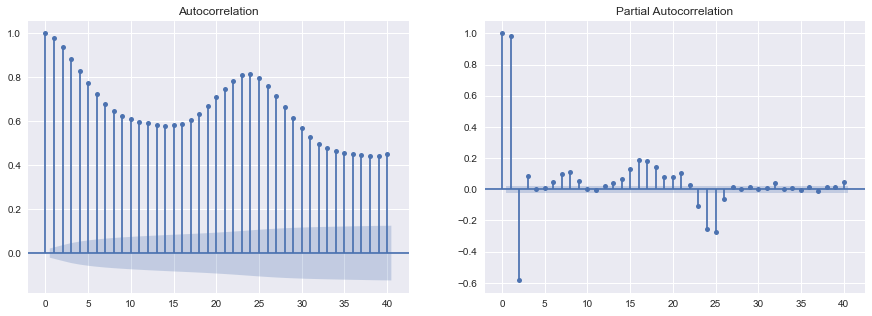

In [14]:
hourly_mod.evaluate()

Next, I run both models with autoregressive terms up to order 3, as inidicated by the PACF.

In [15]:
hourly_mod.bsts(args={'autoregressive' : 3})
hourly_mod.arima(p=3, q=0, D=1)

To visually inspect the in sample performance of the forecasting models, I used the Bokeh library which allows for a plot that can scanned through for ease of interpretability. The plots show the in sample fitted values for both models. Both models do a reasonable job of fitting the seasonality of the Carbon Intensity series.

In [16]:
hourly_mod.visualize()
hourly_mod.visualize(model='arima')

Next, a post model evaluation of the residuals is helpful to see if the residuals still exhibit autocorrelation, as well as seeing an accuracy metric, in this case I chose the root mean squared error.

Comparing the output of the two models, we can see that the bsts model has better in sample performance according to the rmse metric, which the SARIMA model has less residual autocorrelation (but still has it) according to the Ljung-Box statistics. To further test robustness of the two models, out of sample performance would need to be evaluated to ensure the models aren't overfitting.

Root Mean Squared Error of bsts model = 12.64
--------------------------------------------------------------------------------------
Ljung-Box Test of Autocorrelation for Residuals of bsts Model
╒═══════╤═══════════╤══════════════╕
│  Lag  │  lb_stat  │  lb_pvalue   │
╞═══════╪═══════════╪══════════════╡
│   1   │  1092.85  │ 1.18127e-239 │
├───────┼───────────┼──────────────┤
│   2   │  1099.47  │ 1.79549e-239 │
├───────┼───────────┼──────────────┤
│   3   │  1130.9   │ 7.19206e-245 │
╘═══════╧═══════════╧══════════════╛
--------------------------------------------------------------------------------------
Root Mean Squared Error of arima model = 13.94
--------------------------------------------------------------------------------------
Ljung-Box Test of Autocorrelation for Residuals of arima Model
╒═══════╤═══════════╤═════════════╕
│  Lag  │  lb_stat  │  lb_pvalue  │
╞═══════╪═══════════╪═════════════╡
│   1   │  67.8179  │ 1.79315e-16 │
├───────┼───────────┼─────────────┤
│   2   

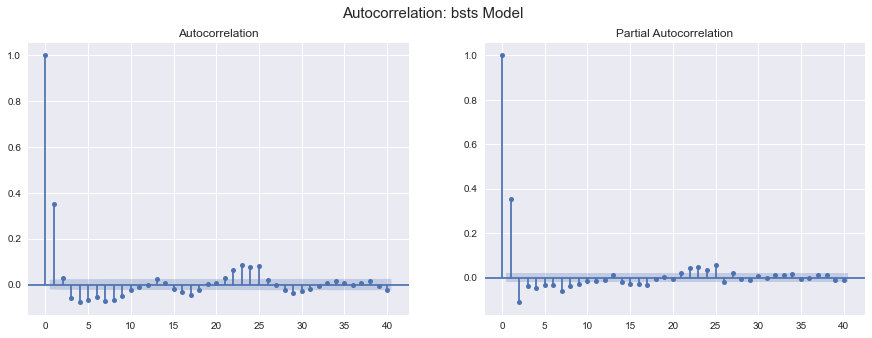

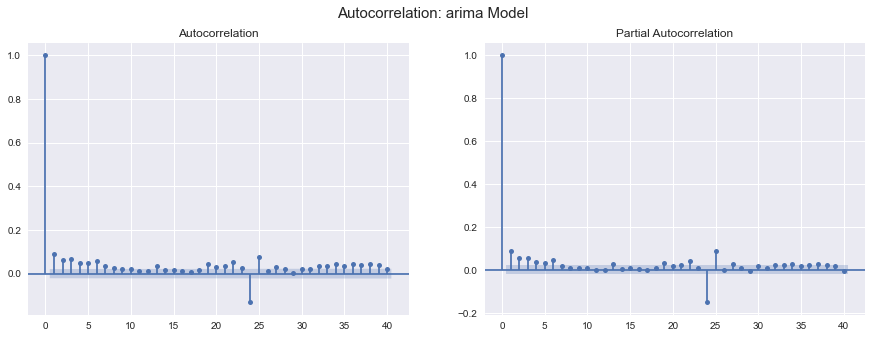

In [17]:
hourly_mod.evaluate(residuals=True)
hourly_mod.evaluate(model='arima', residuals=True)

Finally, these plots show an out of sample forecast for 24 periods ahead for each of the models. With solely visual inspection, we can see that the BSTS model fits the actual values slightly better in sample, in accordance with the better rmse score.

However, we can also see that the out of sample forecast of the SARIMA model is smoother, while the BSTS model has some distinct noise at the end of its forecast. This could potentially indicate overfitting on the part of the BSTS model, which would need to be corrected.

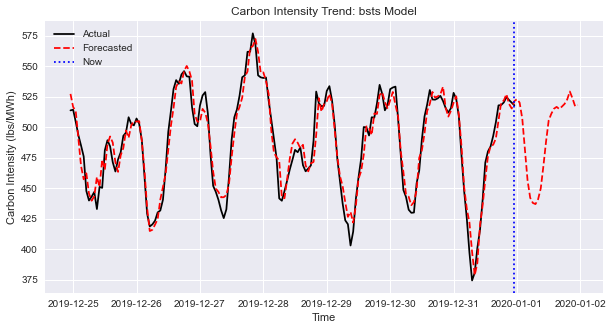

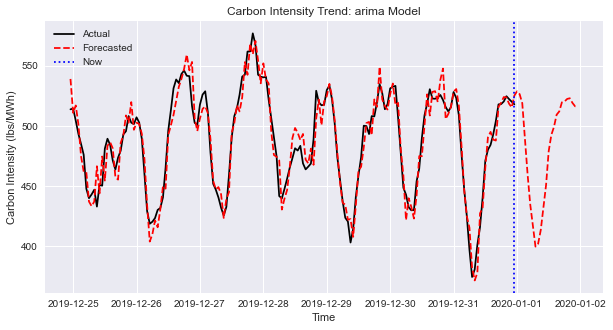

In [18]:
hourly_mod.forecast()
hourly_mod.forecast(model='arima')

We can seet that there is still autocorrelation present in the residuals, even though visually the fit seems to reasonable. This is common in time series forecasting, especially for high frequency data with overlapping seasonalities and cycles, like with electricity data. Further model testing and tuning can help to ensure that the correct fit is achieved. Additionally, multivariate 